# House Price Prediction

## Exploratory Data Analysis

First importing the data, relevant packages and conducting EDA, in preparation for analysis.

In [5]:
import pandas as pd
import forecast
from forecast import histogram, qq_plot
from statlearning import rmse_jack
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import neighbors
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats
import statsmodels.api as sm

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [128]:
import warnings
warnings.filterwarnings('ignore')

In [129]:
house_train = pd.read_csv("train.csv")
house_train.head()

,Train_ID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,60,RL,88.0,12128,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,MnPrv,NaN,0,11,2006,WD,Abnorml,209000
1,2,120,RL,48.0,6240,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2009,WD,Normal,254000
2,3,50,RL,120.0,17360,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,172500
3,4,20,RL,73.0,8688,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,232000
4,5,80,RL,88.0,15312,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2009,COD,Normal,148000


In [130]:
house_test = pd.read_csv("test.csv")
house_test.head()

,Test_ID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,1,80,RL,120.0,19296,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdWo,NaN,0,5,2009,WD,Normal
1,2,20,RL,80.0,10928,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
2,3,160,RL,24.0,2280,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
3,4,20,RL,60.0,8428,Pave,NaN,IR2,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal
4,5,50,RM,50.0,9140,Pave,NaN,Reg,HLS,AllPub,...,200,0,NaN,MnPrv,NaN,0,4,2010,COD,Normal


In [131]:
old_obs_n = house_train.shape[0]
print(f'Train dataset has {house_train.shape[0]} rows and {house_train.shape[1]} columns.')
print(f'Test dataset has {house_test.shape[0]} rows and {house_test.shape[1]} columns.')

Train dataset has 1570 rows and 81 columns.
Test dataset has 1210 rows and 80 columns.


The datasets are moderately large and have a large number of features.

In [132]:
print(f'There are {house_train.isnull().any().sum()} columns in train dataset with missing values.')

There are 24 columns in train dataset with missing values.


There are a number of columns with missing values. These need to be investigated before we engage in feature engineering.

In [133]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(house_train.dtypes)

Train_ID             int64
MS SubClass          int64
MS Zoning           object
Lot Frontage       float64
Lot Area             int64
Street              object
Alley               object
Lot Shape           object
Land Contour        object
Utilities           object
Lot Config          object
Land Slope          object
Neighborhood        object
Condition 1         object
Condition 2         object
Bldg Type           object
House Style         object
Overall Qual         int64
Overall Cond         int64
Year Built           int64
Year Remod/Add       int64
Roof Style          object
Roof Matl           object
Exterior 1st        object
Exterior 2nd        object
Mas Vnr Type        object
Mas Vnr Area       float64
Exter Qual          object
Exter Cond          object
Foundation          object
Bsmt Qual           object
Bsmt Cond           object
Bsmt Exposure       object
BsmtFin Type 1      object
BsmtFin SF 1       float64
BsmtFin Type 2      object
BsmtFin SF 2       float64
B

There are a number of qualitative variables that may require dummy variables to be created for these. This will be applied after an individual inspection of each of the variables in feature engineering.

Before identifying the most ideal features, we will first delve into each of the variables to ensure that the data having been inputted is logically consistent i.e. values correspond logically with the variable.

In [134]:
col_names = list(house_train.columns)

# for i in col_names:
#     plt.hist(house_train[i].dropna(), bins=50);
#     if i == "Year Remod/Add":
#         i = "Year Remod-Add"
#         plt.title(f'Distribution of the {i} variable');
#         plt.savefig(f'Distribution of the {i} variable');
#     else:
#         plt.title(f'Distribution of the {i} variable');
#         plt.savefig(f'Distribution of the {i} variable');
#     plt.show()

Nothing too unusual is noticeable in the data, however there is some skewness to a number of features and should be considered in feature engineering.

Now, using an IQR approach to identifying outliers these should be noted.

In [135]:
# to only consider numerical features in outlier detection
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = house_train.select_dtypes(include=numerics).copy()

In [136]:
del newdf['Train_ID']

In [137]:
Q1 = newdf.quantile(0.25)
Q3 = newdf.quantile(0.75)
IQR = Q3 - Q1

In [138]:
house_train_out = newdf[((newdf < (Q1 - 1.5 * IQR)) |(newdf > (Q3 + 1.5 * IQR))).any(axis=1)].copy()

In [139]:
print(f'The dataset has {house_train_out.shape[0]} outliers.')

The dataset has 966 outliers.


Since, there were 966 observations that contain at least one outlier under one of its features, this representing a significant proportion of the train dataset it was considered that these would not be ignored in training.

## Feature Engineering

First we will examine for the most relevant numerical variables in the dataset. Later, the categorical features will be converted to dummies so that they can be usable for predictive modelling.

Minusing the year it was sold in to the year it was constructed the new variable 'Age' was created. Also, minusing the last year it was remodelled or had additions made to the house to the year it was sold was added as the 'Last remod/add' feature. 

In [140]:
house_train['Age'] = house_train['Yr Sold'] - house_train['Year Built']
house_train['Last remod/add'] = house_train['Yr Sold'] - house_train['Year Remod/Add']

house_test['Age'] = house_test['Yr Sold'] - house_test['Year Built']
house_test['Last remod/add'] = house_test['Yr Sold'] - house_test['Year Remod/Add']

In [141]:
num_house_train = house_train[['MS SubClass','Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1',
'BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area',
'Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Cars',
'Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area',
'Misc Val','Age','Last remod/add','SalePrice']].copy()

Let's create a series of scatter plots of the narrowed numerical features against 'SalePrice' to understand what relationships may be present between these variables.

In [142]:
# col_names = list(num_house_train.columns)

# for i in col_names:
#     plt.scatter(num_house_train[i], num_house_train['SalePrice'], alpha = 0.5);
#     plt.title(f'Relationship between Sale Price and the {i} variable');
#     sns.set(font_scale=1)
#     plt.xlabel(i)
#     plt.ylabel("SalePrice")
#     if i == "Last remod/add":
#         plt.savefig(f'Relationship between Sale Price and the Last remod-add variable',bbox_inches='tight')
#     else:
#         plt.savefig(f'Relationship between Sale Price and the {i} variable',bbox_inches='tight')
#     plt.show()

Viewing the scatter plots the best variables to consider are "Gr Liv Area", "Garage Area", "Age", "Last remod/add", "Total Bsmt SF", "1st Flr SF", '2nd Flr SF', “BsmtFin SF 1”, “Full Bath”, “TotRms AbvGrd”, “Fireplaces” and “Garage Cars”.  This is due to these showing some form of a non-linear relationship.

In [143]:
# MAY OR MAY NOT NEED? ONLY IF THERE WERE FEATURES THAT WOULD HAVE CONTAINED NA VALUES THAT 
#WOULD HAVE BEEN HARD TO JUSTIFY AS A DUMMY CAUSE NO ADDITIONAL INFO ON THEM

# nan_values = num_house_train_out.isna()
# nan_columns = nan_values.any()

# columns_with_nan = num_house_train_out.columns[nan_columns].tolist()
# columns_with_nan

In [144]:
# MAY OR MAY NOT NEED? ONLY IF THERE WERE FEATURES THAT WOULD HAVE CONTAINED NA VALUES THAT 
#WOULD HAVE BEEN HARD TO JUSTIFY AS A DUMMY CAUSE NO ADDITIONAL INFO ON THEM

# nan_values = house_test.isna()
# nan_columns = nan_values.any()

# columns_with_nan = house_test.columns[nan_columns].tolist()
# columns_with_nan

To see if any relationship is present between the categorical variables and the Sales Price predictor, box plots will be made between these.

In [145]:
num_var = ['MS SubClass','Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1',
'BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF','2nd Flr SF','Low Qual Fin SF','Gr Liv Area',
'Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces','Garage Cars',
'Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area',
'Misc Val','Age','Last remod/add','SalePrice']

col_names = list(house_train.columns)

def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

cat_var = returnNotMatches(col_names, num_var)[0]
cat_var.remove('Train_ID')
cat_var.remove('Year Built')
cat_var.remove('Year Remod/Add')
cat_var.remove('Garage Yr Blt')

NA values of the categorical variables were replaced with the string "NONE(na rep)". This was to observe if there was any meaningful relationships between the missing values and price.

In [146]:
house_train[cat_var] = house_train[cat_var].fillna('NONE(na rep)')

In [147]:
# for i in cat_var:
#     figure(num=None, figsize=(10, 8))
#     house_train[i] = house_train[i].astype(str)
#     x=dict(house_train.groupby([i])['SalePrice'].median())
#     sns.boxplot(x = house_train[i], y = house_train['SalePrice'], boxprops=dict(alpha=.3), order = list({k: v for k, v in sorted(x.items(), key=lambda item: item[1])}));
# #     boxplot_sorted(house_train_out, by = [i], column = 'SalePrice')
#     sns.stripplot(x=i, y="SalePrice", data=house_train, alpha=0.7, order = list({k: v for k, v in sorted(x.items(), key=lambda item: item[1])}))
#     plt.title(f'Relationship between Sale Price and the {i} variable');
#     plt.xticks(rotation=30)
#     sns.set(font_scale=1.6)
#     plt.xlabel(i)
#     plt.ylabel("SalePrice")
#     plt.savefig(f'Relationship between Sale Price and the {i} variable',bbox_inches='tight')
#     plt.show()

The best categorical features would be "Kitchen Qual", "Garage Finish" and "Overall Quality". This was on the basis that there was a sufficient number of observations between the different categories, a clear pattern was evident and that the variation (the whiskers of the boxplots) between groups did not overlap excessively. "Alley" would have also been considered, however, the presence of NA values that did not show a pattern or a distinct variation between the other categories meant NA values had little meaning.

Before confirming the final subset of features, to ensure that there were no issues in training and evaluation features that contained NA values were to be dropped or imputed with an average.

In [148]:
df_subset = house_train[["SalePrice", "Gr Liv Area", "Garage Area", "Age", 
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", "Kitchen Qual", "Overall Qual", "Garage Finish", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']].copy()

df_subset_test = house_test[["Gr Liv Area", "Garage Area", "Age", 
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", "Kitchen Qual", "Overall Qual", "Garage Finish", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']].copy()

In [149]:
print(f'There are {df_subset.isnull().any().sum()} columns in train dataset with missing values.')

There are 2 columns in train dataset with missing values.


In [150]:
nan_values = df_subset.isna()
nan_columns = nan_values.any()

columns_with_nan = df_subset.columns[nan_columns].tolist()
columns_with_nan

['Total Bsmt SF', 'BsmtFin SF 1']

In [151]:
df_subset['Garage Finish'] = df_subset['Garage Finish'].fillna('NONE(na rep)')

In [152]:
null_data = df_subset[df_subset.isnull().any(axis=1)]
null_data

,SalePrice,Gr Liv Area,Garage Area,Age,Last remod/add,Total Bsmt SF,1st Flr SF,Kitchen Qual,Overall Qual,Garage Finish,2nd Flr SF,BsmtFin SF 1,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars
508,79000,896,280,62,58,NaN,896,TA,4,Unf,0,NaN,1,4,0,1


In [153]:
df_subset['Total Bsmt SF'] = df_subset['Total Bsmt SF'].fillna(df_subset_test['Total Bsmt SF'].mean())
df_subset['BsmtFin SF 1'] = df_subset['BsmtFin SF 1'].fillna(df_subset_test['BsmtFin SF 1'].mean())

The missing values under "Total Bsmt SF" and "BsmtFin SF 1" were replaced with their respective mean.

The same check was repeated for the test set to ensure that no evaluation errors occur.

In [154]:
nan_values = df_subset_test.isna()
nan_columns = nan_values.any()

columns_with_nan = df_subset_test.columns[nan_columns].tolist()
columns_with_nan

['Garage Area', 'Garage Finish', 'Garage Cars']

In [155]:
df_subset_test['Garage Finish'] = df_subset_test['Garage Finish'].fillna('NONE(na rep)')

In [156]:
null_data = df_subset_test[df_subset_test.isnull().any(axis=1)]
null_data

,Gr Liv Area,Garage Area,Age,Last remod/add,Total Bsmt SF,1st Flr SF,Kitchen Qual,Overall Qual,Garage Finish,2nd Flr SF,BsmtFin SF 1,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars
941,1828,NaN,84,8,859,942,Gd,5,NONE(na rep),886,548,2,6,0,NaN


Provided that only one observation had a NA value for "Garage Area" and "Garage Cars" it was best to imput the values of this single row with their means rather than removing the entire "Garage Area" variable.

In [157]:
# df_subset_test = df_subset_test.drop([941])
df_subset_test['Garage Area'] = df_subset_test['Garage Area'].fillna(df_subset_test['Garage Area'].mean())
df_subset_test["Garage Cars"] = df_subset_test["Garage Cars"].fillna(df_subset_test["Garage Cars"].mean())

It was noticed that during model evaluation some of the observations in the test dataset under "Kitchen Qual" contained observations that had a category not defined in the training set.

In [158]:
df_subset["Kitchen Qual"].unique()

array(['Ex', 'Gd', 'TA', 'Fa'], dtype=object)

In [159]:
df_subset_test["Kitchen Qual"].unique()

array(['TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [160]:
df_subset_test[df_subset_test["Kitchen Qual"] == 'Po']

,Gr Liv Area,Garage Area,Age,Last remod/add,Total Bsmt SF,1st Flr SF,Kitchen Qual,Overall Qual,Garage Finish,2nd Flr SF,BsmtFin SF 1,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars
52,1224,180.0,93,60,689,725,Po,5,Unf,499,0,1,6,0,1.0


Therefore, the following features that were considered for model construction and evaluation were "SalePrice", "Gr Liv Area", "Garage Area", "Age", "Last remod/add", "Total Bsmt SF", "1st Flr SF", "Kitchen Qual", "Overall Qual", "Garage Finish", '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces' and 'Garage Cars'.

To finish feature engineering the train and test narrowed dataframes were finalised with its numerical variables being standardised. Typically the categorical variables would have been dummified here too, however, to simplify the model construction workflow this will be done just before the subset of features is being used to train the model.

In [161]:
# train-set transformations
num_predictors_train = ["Gr Liv Area", "Garage Area", "Age", 
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']

mu=df_subset[num_predictors_train].mean() # mean for each feature
sigma=df_subset[num_predictors_train].std() # std for each feature

df_subset[num_predictors_train]=(df_subset[num_predictors_train]-mu)/sigma

# test-set transformations

num_predictors_test = ["Gr Liv Area", "Garage Area", "Age", 
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']

mu=df_subset_test[num_predictors_test].mean() # mean for each feature
sigma=df_subset_test[num_predictors_test].std() # std for each feature

df_subset_test[num_predictors_test]=(df_subset_test[num_predictors_test]-mu)/sigma

## Model Construction

### kNN Regression

Using subset selection amongst the narrowed variables the most optimal model was derived. Please note that this regression was performed only with the dataset containing outliers.

In [162]:
def knn_multiple_test(features, response):
    
    best_features_score = np.inf
    best_test_t = np.inf
    
    for predictors in features:
    
        neighbours=np.arange(1, 51)
        best_score = -np.inf
        
        for k in neighbours: 
            if len(predictors) == 1:
                knn = KNeighborsRegressor(n_neighbors= k) 
                scores = cross_val_score(knn, pd.get_dummies(df_subset[predictors], drop_first=True), df_subset[response], cv=5, scoring = 'neg_mean_squared_error')
                cv_score = np.mean(scores)
                if cv_score >= best_score:
                    best_score = cv_score
                    best_knn = knn
            else:
                knn = KNeighborsRegressor(n_neighbors = k) 
                scores = cross_val_score(knn, pd.get_dummies(df_subset[predictors], drop_first=True), df_subset[response], cv=5, scoring = 'neg_mean_squared_error')
                # taking the average of scores across 5 folds
                cv_score = np.mean(scores)
                # use the cv score for model selection
                if cv_score >= best_score:
                    best_score = cv_score
                    best_knn = knn

        knn = best_knn
        # train the selected model with the whole train set
        knn.fit(pd.get_dummies(df_subset[predictors], drop_first=True), df_subset[response])
        # Predict the test data with the selected and re-estimated model
        predictions = knn.predict(pd.get_dummies(df_subset_test[predictors], drop_first=True))
        # test_rmse = np.sqrt(mean_squared_error(nba_test_knn[response], predictions))
        cv_rmse = np.sqrt(-best_score)
        print(f'For feature selection {predictors} best K is {knn.n_neighbors}')
        print(f'Cross Validation RMSE: {cv_rmse}')
        # print(f'Test RMSE: {test_rmse}')
        print('-------------------------------------------')
        
        if cv_rmse < best_features_score:
            best_features_score = cv_rmse
            # best_test = test_rmse
            best_features = predictors
            best_overall_knn = best_knn
            best_predictions = predictions
            
#         if test_rmse < best_test_t:
#             best_features_score_t = cv_rmse
#             best_test_t = test_rmse
#             best_features_t = predictors
#             best_overall_knn_t = best_knn
            
#     print(f'Best kNN model uses the features {best_features}')
#     print(f'Best CV RMSE: {best_features_score}')
#     print(f'Best Test RMSE: {best_test}')
    print('-------------------------------------------')
    print('-------------------------------------------')
    print('-------------------------------------------')
    
    return [best_features, best_overall_knn, best_features_score, best_predictions]

In [163]:
# getting the different combinations of features sets

all_features = ["Gr Liv Area", "Garage Area", "Age", 
                      "Last remod/add", "Total Bsmt SF", 
                      "1st Flr SF", "Garage Finish", 'Overall Qual', '2nd Flr SF', 
                      'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 
                      'Fireplaces', 'Garage Cars']

feature_combinations = []

for i in range(12,len(all_features)+1):
    subsets = list(itertools.combinations(all_features, i))
    for k in subsets:
        feature_combinations.append(list(k))

len(feature_combinations)

106

In [164]:
best_set_model = []

best_set_model.append(knn_multiple_test(feature_combinations, 'SalePrice'))

overall_best_score = np.inf
for i in best_set_model:
    if i[2] < overall_best_score:
        overall_best_score = i[2]
        overall_best_features = i[0]
        overall_best_knn_cv = i[1]
        overall_best_predictions = i[3]
        
print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best kNN model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')
print(f'Number of neighbours: {overall_best_knn_cv.n_neighbors}')

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd'] best K is 7
Cross Validation RMSE: 31558.357497306344
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces'] best K is 8
Cross Validation RMSE: 30899.74019816272
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars'] best K is 8
Cross Validation RMSE: 31701.703788540097
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best K is 5
Cross Validation RMSE: 31771.963770427385
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best K is 6
Cross Validation RMSE: 32671.451153196653
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best K is 6
Cross Validation RMSE: 32170.325498801136
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garag

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best K is 5
Cross Validation RMSE: 32152.460495177686
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best K is 8
Cross Validation RMSE: 31345.510898716464
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best K is 7
Cross Validation RMSE: 31370.398468716117
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total 

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best K is 5
Cross Validation RMSE: 34763.59417551497
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best K is 7
Cross Validation RMSE: 32027.903589198457
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best K is 5
Cross Validation RMSE: 33241.97704093023
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual

In [166]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("new_predictions-with-overall-qual/Predictions_knn_with_outliers.csv")

# kaggle test-rmse = 31024.5182

### Multiple Linear Regression

In [167]:
def mlr_multiple_test(features, response, train_dataset, test_dataset):
    
    best_features_score = np.inf
    best_test_t = np.inf
    
    for predictors in features:
    
        best_score = -np.inf
        
        mlr = LinearRegression()

        scores = cross_val_score(mlr, pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response], cv=5, scoring = 'neg_mean_squared_error')
        cv_score = np.mean(scores)
        
        # train the selected model with the whole train set
        mlr.fit(pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response])
        
        # Predict the test data with the selected and re-estimated model
        predictions = mlr.predict(pd.get_dummies(test_dataset[predictors], drop_first=True))
        cv_rmse= np.sqrt(-cv_score)        
        
        print(f'For feature selection {predictors}')
        print(f'Cross Validation RMSE: {cv_rmse}')
        print('-------------------------------------------')
        
        if cv_rmse < best_features_score:
            best_features_score = cv_rmse
            best_features = predictors
            best_overall = mlr
            best_predictions = predictions
            
#     print(f'Best kNN model uses the features {best_features}')
#     print(f'Best CV RMSE: {best_features_score}')
#     print(f'Best Test RMSE: {best_test}')
    print('-------------------------------------------')
    print('-------------------------------------------')
    print('-------------------------------------------')

    return [best_features, best_overall, best_features_score, best_predictions]

In [168]:
best_set_model = []

best_set_model.append(mlr_multiple_test(feature_combinations, 'SalePrice', df_subset, df_subset_test))

overall_best_score = np.inf
for i in best_set_model:
    if i[2] < overall_best_score:
        overall_best_score = i[2]
        overall_best_features = i[0]
        overall_best_mlr_cv = i[1]
        overall_best_predictions = i[3]
        
print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best MLR model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 35305.53619104749
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 35243.60737239074
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 35387.91289818742
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 36221.417654587196
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 35245.20983374106
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 38898.6642818778
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '

In [169]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("new_predictions-with-overall-qual/Predictions_linear_with_outliers.csv")
# kaggle test-rmse = 39385.1014

### Polynomial Regression

In [170]:
def poly_multiple_test(features, response, train_dataset, test_dataset):
    
    best_features_score = np.inf
    best_test_t = np.inf
    
    for predictors in features:
    
        degrees=np.arange(1, 5)
        best_score = -np.inf
        x_train = pd.get_dummies(train_dataset[predictors], drop_first=True).to_numpy()
        
        for k in degrees:
            
            poly_transformer = PolynomialFeatures(k)
            poly_x = poly_transformer.fit_transform(x_train)
            
            
            pr = LinearRegression()
            scores = cross_val_score(pr, poly_x, train_dataset[response].to_numpy(), cv=5, scoring = 'neg_mean_squared_error')
            cv_score = np.mean(scores)
            if cv_score >= best_score:
                best_score = cv_score
                best_poly = pr
                best_degree = k
                best_x = poly_x

        pr = best_poly        
        # train the selected model with the whole train set
        pr.fit(best_x, train_dataset[response].values)
        # Predict the test data with the selected and re-estimated model
        poly_transformer_test = PolynomialFeatures(best_degree)
        x_test = pd.get_dummies(test_dataset[predictors], drop_first=True).to_numpy()
        poly_x_test = poly_transformer_test.fit_transform(x_test)
        predictions = pr.predict(poly_x_test)
        # test_rmse = np.sqrt(mean_squared_error(nba_test_knn[response], predictions))
        cv_rmse = np.sqrt(-best_score)
        print(f'For feature selection {predictors} best degree is {k}')
        print(f'Cross Validation RMSE: {cv_rmse}')
        # print(f'Test RMSE: {test_rmse}')
        print('-------------------------------------------')
        
        if cv_rmse < best_features_score:
            best_features_score = cv_rmse
            # best_test = test_rmse
            best_features = predictors
            best_overall_pr = pr
            best_predictions = predictions
            
#         if test_rmse < best_test_t:
#             best_features_score_t = cv_rmse
#             best_test_t = test_rmse
#             best_features_t = predictors
#             best_overall_knn_t = best_knn
            
#     print(f'Best kNN model uses the features {best_features}')
#     print(f'Best CV RMSE: {best_features_score}')
#     print(f'Best Test RMSE: {best_test}')
    print('-------------------------------------------')
    print('-------------------------------------------')
    print('-------------------------------------------')
    
    return [best_features, best_overall_pr, best_features_score, predictions]

In [171]:
#### DON'T FORGET TO ADJUST ALGO TO CONVERT CATEGORICAL VARIABLES TO DUMMIES...

best_set_model = []

best_set_model.append(poly_multiple_test(feature_combinations, 'SalePrice', df_subset, df_subset_test))

overall_best_score = np.inf
for i in best_set_model:
    if i[2] < overall_best_score:
        overall_best_score = i[2]
        overall_best_features = i[0]
        overall_best_mlr_cv = i[1]
        overall_best_predictions = i[3]
        
print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best POLY model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd'] best degree is 4
Cross Validation RMSE: 35305.53619104749
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces'] best degree is 4
Cross Validation RMSE: 35243.607372390725
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars'] best degree is 4
Cross Validation RMSE: 35387.91289818742
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces'] best degree is 4
Cross Validation RMSE: 35025.773493211535
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 4
Cross Validation RMSE: 35254.678865270806
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best degree is 4
Cross Validation RMSE: 34756.66333537586
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bs

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars'] best degree is 4
Cross Validation RMSE: 35387.894915413744
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars'] best degree is 4
Cross Validation RMSE: 35367.80431130767
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 4
Cross Validation RMSE: 35129.21674699248
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/

For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 4
Cross Validation RMSE: 35792.750433475565
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 4
Cross Validation RMSE: 38385.15449284822
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars'] best degree is 4
Cross Validation RMSE: 35165.422327549386
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Fin

In [172]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("new_predictions-with-overall-qual/Predictions_poly_with_outliers.csv")
# kaggle test-rmse = 39331.2954

## Random Forest Regression

In [173]:
def rf_multiple_test(features, response, train_dataset, test_dataset):
    
    best_features_score = np.inf
    best_test_t = np.inf
    
    for predictors in features:
        
        best_score = -np.inf
        
        rf = RandomForestRegressor()

        scores = cross_val_score(rf, pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response], cv=5, scoring = 'neg_mean_squared_error')
        cv_score = np.mean(scores)
        
        # train the selected model with the whole train set
        rf.fit(pd.get_dummies(train_dataset[predictors], drop_first=True), train_dataset[response])
        
        # Predict the test data with the selected and re-estimated model
        predictions = rf.predict(pd.get_dummies(test_dataset[predictors], drop_first=True))
        cv_rmse= np.sqrt(-cv_score)        
        
        print(f'For feature selection {predictors}')
        print(f'Cross Validation RMSE: {cv_rmse}')
        print('-------------------------------------------')
        
        if cv_rmse < best_features_score:
            best_features_score = cv_rmse
            best_features = predictors
            best_overall = rf
            best_predictions = predictions
            
#     print(f'Best kNN model uses the features {best_features}')
#     print(f'Best CV RMSE: {best_features_score}')
#     print(f'Best Test RMSE: {best_test}')
    print('-------------------------------------------')
    print('-------------------------------------------')
    print('-------------------------------------------')

    return [best_features, best_overall, best_features_score, best_predictions]

In [174]:
#### DON'T FORGET TO ADJUST ALGO TO CONVERT CATEGORICAL VARIABLES TO DUMMIES...

best_set_model = []

best_set_model.append(rf_multiple_test(feature_combinations, 'SalePrice', df_subset, df_subset_test))

overall_best_score = np.inf
for i in best_set_model:
    if i[2] < overall_best_score:
        overall_best_score = i[2]
        overall_best_features = i[0]
        overall_best_rf_cv = i[1]
        overall_best_predictions = i[3]
        
print('-------------------------------------------')    
print('-------------------------------------------')        
print('------OVERALL BEST MODEL BY CV-RMSE--------')        
print('-------------------------------------------')        
print('-------------------------------------------')        

print(f'Overall Best RF model uses the features {overall_best_features}')
print(f'CV RMSE: {overall_best_score}')

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd']
Cross Validation RMSE: 29499.212576799902
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces']
Cross Validation RMSE: 29282.58471773739
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Garage Cars']
Cross Validation RMSE: 29596.456126778437
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 

For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Garage Cars']
Cross Validation RMSE: 29763.716346017394
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 29202.87927344351
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 29267.35127338149
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Age', 'Last remod/add', 'Total Bsmt SF', 'Garage Finish', 'Overall Qual', '2nd Flr 

For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 29504.03670376455
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 29596.844074035493
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 29744.075657732326
-------------------------------------------
For feature selection ['Gr Liv Area', 'Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Fini

For feature selection ['Garage Area', 'Age', 'Last remod/add', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 30032.416575554962
-------------------------------------------
For feature selection ['Garage Area', 'Age', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 29960.535822576658
-------------------------------------------
For feature selection ['Garage Area', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin SF 1', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars']
Cross Validation RMSE: 30013.176008705064
-------------------------------------------
For feature selection ['Age', 'Last remod/add', 'Total Bsmt SF', '1st Flr SF', 'Garage Finish', 'Overall Qual', '2nd Flr SF', 'BsmtFin S

In [175]:
predictions = pd.concat([pd.Series(df_subset_test.index), pd.Series(overall_best_predictions)], axis=1, ignore_index=True)
predictions = predictions.rename(columns={1: "SalePrice"})
predictions = predictions.drop([0], axis=1)
predictions.index.names = ['Test_ID']
predictions.to_csv("new_predictions-with-overall-qual/Predictions_rf_with_outliers-best.csv")
# kaggle test-rmse = 27509.3312 (note this was without overal qual)

# use sci-kit learn outlier detection methods but first do write up to outlier detection section... remember methodology should include mathematical theory... from assignment 1 feedback???

In [160]:
# def poly_multiple_test(features, response, train_dataset, test_dataset, degrees):
    
#     best_features_score = np.inf
#     best_test_t = np.inf
    
#     for predictors in features:
    
#         best_score = -np.inf
#         x_train = pd.get_dummies(train_dataset[predictors], drop_first=True).to_numpy()
        

#         poly_transformer = PolynomialFeatures(degrees)
#         poly_x = poly_transformer.fit_transform(x_train)


#         pr = LinearRegression()
#         scores = cross_val_score(pr, poly_x, train_dataset[response].to_numpy(), cv=5, scoring = 'neg_mean_squared_error')
#         cv_score = np.mean(scores)
     
#         # train the selected model with the whole train set
#         pr.fit(x_train, train_dataset[response])
#         # Predict the test data with the selected and re-estimated model
#         poly_transformer_test = PolynomialFeatures(degrees)
#         x_test = pd.get_dummies(test_dataset[predictors], drop_first=True).to_numpy()
#         poly_x_test = poly_transformer_test.fit_transform(x_test)
#         predictions = pr.predict(poly_x_test)
#         # test_rmse = np.sqrt(mean_squared_error(nba_test_knn[response], predictions))
#         cv_rmse = np.sqrt(-cv_score)
#         print(f'For feature selection {predictors} degree is 6')
#         print(f'Cross Validation RMSE: {cv_rmse}')
#         # print(f'Test RMSE: {test_rmse}')
#         print('-------------------------------------------')
        
#         if cv_rmse < best_features_score:
#             best_features_score = cv_rmse
#             # best_test = test_rmse
#             best_features = predictors
#             best_overall_pr = pr
#             best_predictions = predictions
            
# #         if test_rmse < best_test_t:
# #             best_features_score_t = cv_rmse
# #             best_test_t = test_rmse
# #             best_features_t = predictors
# #             best_overall_knn_t = best_knn
            
# #     print(f'Best kNN model uses the features {best_features}')
# #     print(f'Best CV RMSE: {best_features_score}')
# #     print(f'Best Test RMSE: {best_test}')
#     print('-------------------------------------------')
#     print('-------------------------------------------')
#     print('-------------------------------------------')
    
#     return [best_features, best_overall_pr, best_features_score, predictions]

# Forecasting Country Visitors

In [40]:
df = pd.read_csv("Visitors.csv")
df['Date'] = '01-' + df['Date'].astype(str)
df['Date'] = df['Date'].apply(pd.to_datetime)
df.index=df['Date']
df.index=df.index.to_period(freq='M')
df=df.drop(['Date'], axis=1)
df.tail()

,Number of Visitors
Date,
2016-08,632600
2016-09,647200
2016-10,694300
2016-11,720500
2016-12,971800


In [41]:
y = df['Number of Visitors']
df = pd.read_csv("Visitors.csv")
series = df['Number of Visitors']

## Explorartory Data Analysis

The following plots the pattern change in the number of visitors entering the country from 1991 to 2016. Using this we were able to delineate the overall seasonality and trend of the data.

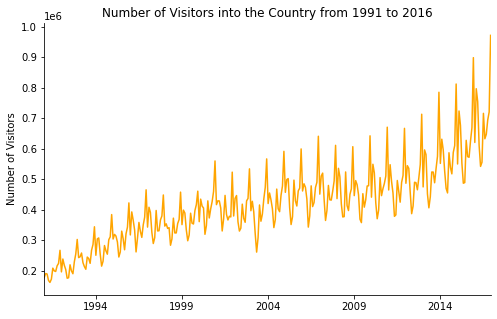

In [42]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color='orange')
ax.set_xlabel('')
ax.set_ylabel('Number of Visitors')
ax.set_title('Number of Visitors into the Country from 1991 to 2016')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

Therefore, it was apparent that the data seemed to follow some rough yearly seasonality. A consistent upward trend was also observed while variance appeared to increase towards 2016. To understand the variations further a timeseries decomposition can be viewed as below.

In [43]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# components = seasonal_decompose(df, model='additive')
# components.plot()

In [44]:
y.describe().round(4)

count       312.0000
mean     419407.3718
std      132443.0593
min      161400.0000
25%      332625.0000
50%      412950.0000
75%      488775.0000
max      971800.0000
Name: Number of Visitors, dtype: float64

Moreover, the mean entrance of visitors is 419307 across the entire timeframe (1991-2016). Also the highest recorded number was 971800 while the lowest was 161400.

### Multiplicative Holt-Winters Exponential Smoothing

#### Rationale

The Holt-Winters exponential smoothing model considers trend and seasonal correctional methods. Therefore, the following model was selected on the rationale of seasonality and trend variations being key patterns in the data, as observed in the EDA.

Also it is known that the additive model is most appropriate for data that has seasonal variations that are roughly constant across the provided period, while a multiplicative one suits data when the seasonal variation is proportional to the trend. Since the EDA showed that the variance of seasonal periods increased towards 2016 it made sense to proceed with a model formulation that applied the multiplicative method. 

#### Methodology

The selected model compromises of three different components, these being the level, trend and seasonal indices. (use equations below this line) Thus, predictions of the future or of current instances are computed on the basis of these three influences.  

Using exponential smoothing across these different aspects that the model considers, it determines a weight for past observations. This means that the model gives greater weight to observations recorded more recent, than those recorded before them. Hence, parameters alpha, beta and delta influence the level of exponential smoothing applied to level, trend and seasonal components respetively. These values are optimised using least squares. (put argmin equation below)

Before deriving any forecasts, diagnostics were performed to ensure that the model was appropriate in forecasting of the provided data. 

#### Diagnostics

In [45]:
mhw=forecast.holtwinters(y, additive=False, damped=False, m=12)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.310 (0.078)
 beta  (trend)    0.012 (0.008)
 delta (seasonal) 0.362 (0.050)
 
 In-sample fit:
 MSE               434674551.141
 RMSE              20848.850
 Log-likelihood   -3545.566
 AIC               7099.131
 BIC               7114.103


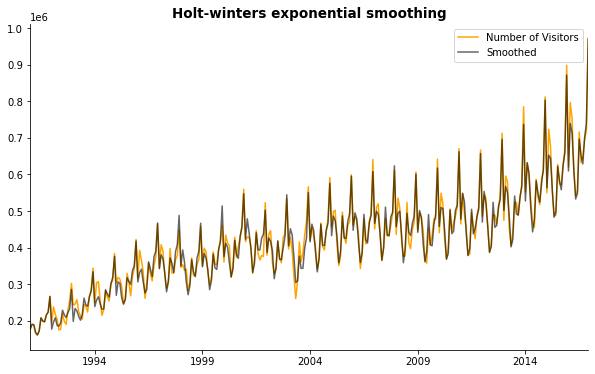

In [46]:
smoothed=pd.Series(mhw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='orange', label='Number of Visitors')
smoothed.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

Holt-Winters exponential smoothing curve following very closely with the data was a good indication of model use for the given data. 

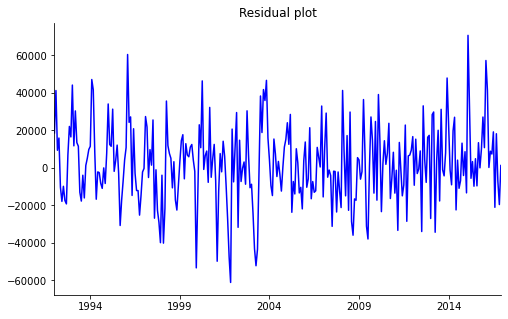

In [47]:
resid = (y-mhw.smooth())[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color='blue')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

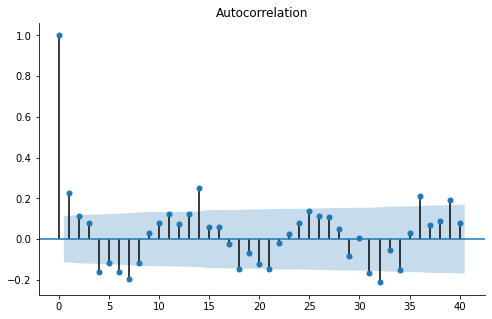

In [48]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

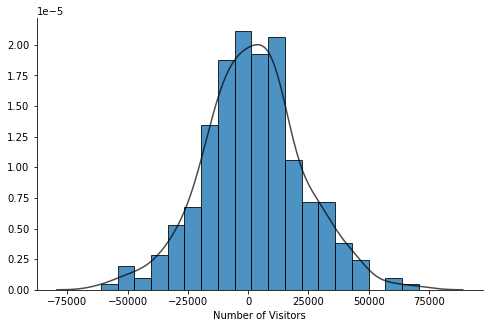

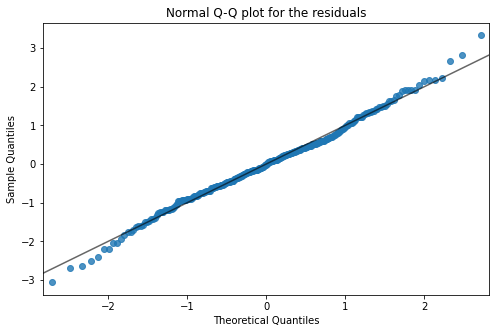

In [49]:
histogram(resid)
plt.show()

qq_plot(resid)
plt.show()

The residuals appeared not to follow any particular pattern, however, a qqplot of them showed some slight deviation from the line, through which did raise some concern for normality. Moreover, the autocorrelations did not give any unusual results and were reasonable. Thus, provided these diagnostics, other than the slight concern for normality, the model was confirmed appropriate for the data.   

#### Model Validation

In [50]:
# Real time forecasting 


validation=y['2008-01':].index
start = y.index.get_loc('2008-01') 

pred = []
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=12)
    model.fit()
    pred.append(model.forecast(1)[0]) # multiplicate holt winters forecast

columns=['Holt-Winters Multiplicative', 'Actual']
results = np.vstack([pred, actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [52]:
table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)
#23645.48	2140.26

,RMSE,SE
Holt-Winters Multiplicative,23645.48,2140.26


Now, we were able to use the best derived model from above to determine the 24 month forecast for the number of visitors into the country.

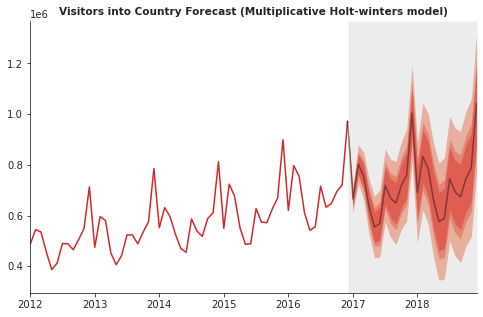

In [53]:
h=24

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='M')

pred=pd.Series(mhw.forecast(h), index=test)
var = mhw.forecastvariance(h)
# pred=np.exp(pred+var/2) # retransformation under the assumption of normality, for simplicity

intv1=pd.DataFrame(mhw.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(mhw.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(mhw.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(y['01-2012':], pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Visitors into Country Forecast (Multiplicative Holt-winters model)', fontsize=10.5, fontweight='bold')
sns.despine()
plt.show()

### Multiplicative Holt-Winters Exponential Smoothing with Dampening

#### Rationale

Since the multiplicative Holt-Winters Exponential Smoothing with Dampening model follows very similar principles to the previous model, the same rationale applies. However, the addition of dampening also allows us to address the potential issue of extrapolating the trend indefinitely into the future. Therefore, producing such a model should be able to prevent the resulting of implausible forecasts.

#### Methodology

The model follows the same principles and components of the previous one, but with the inclusion of a dampening parameter (phi). Effectively , this applies an additional weight to both the seasonality and trend components. (Show new equations below).

#### Diagnostics

In [54]:
mhw=forecast.holtwinters(y, additive=False, damped=True, m=12)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.482 (0.077)
 beta  (trend)    0.000 (0.029)
 delta (seasonal) 0.412 (0.086)
 phi (damping)    0.792 (0.054)
 
 In-sample fit:
 MSE               445818496.985
 RMSE              21114.414
 Log-likelihood   -3549.515
 AIC               7109.029
 BIC               7127.744


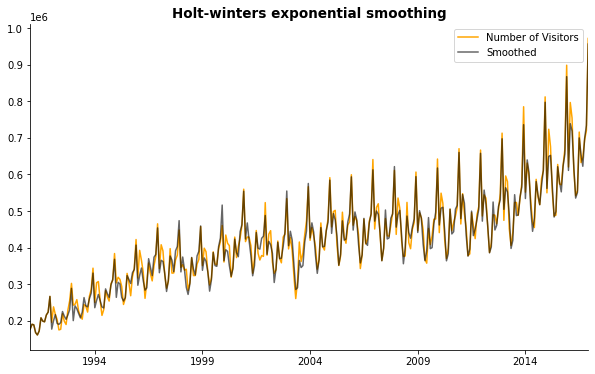

In [55]:
smoothed=pd.Series(mhw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='orange', label='Number of Visitors')
smoothed.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

Holt-Winters exponential smoothing curve with dampening following very closely with the data was a good indication of model use for the given data. 

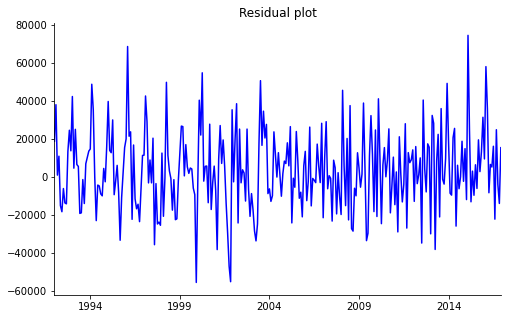

In [56]:
resid = (y-mhw.smooth())[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color='blue')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

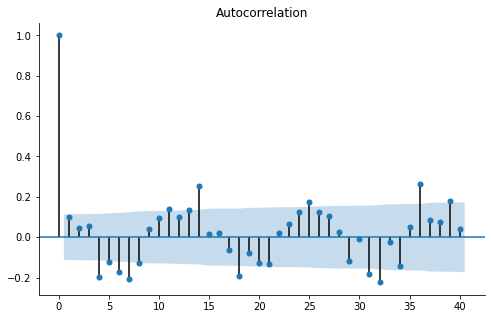

In [57]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

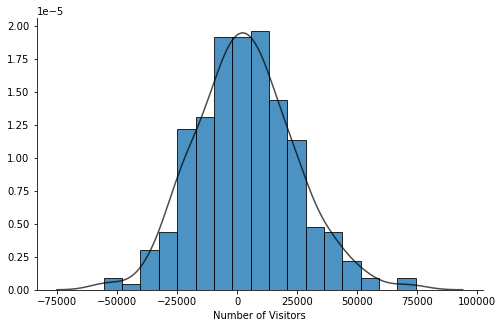

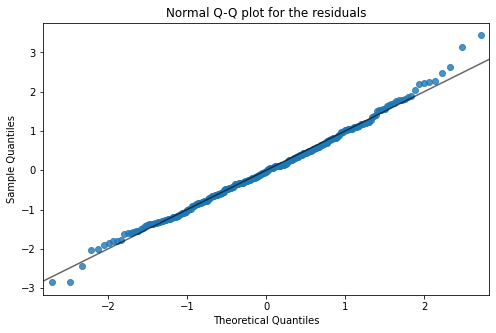

In [58]:
histogram(resid)
plt.show()

qq_plot(resid)
plt.show()

Similarly, to the previous model the residuals did not follow any patterns, while normality was also questionable but relatively reasonable with the slight deviations from the line at the extremities. Moreover, the autocorrelations were also not an issue with these not containing any high values.

### Model Validation and Selection

In [66]:
# Real time forecasting 


validation=y['2008-01':].index
start = y.index.get_loc('2008-01') 

pred = []
pred1 = []
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=12)
    model.fit()
    pred.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=True, m=12)
    model.fit()
    pred1.append(model.forecast(1)[0]) # multiplicate holt winters forecast with dampening

columns=['Holt-Winters Multiplicative', 'Holt-Winters Multiplicative (with dampening)', 'Actual']
results = np.vstack([pred, pred1, actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [68]:
table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)

,RMSE,SE
Holt-Winters Multiplicative,23645.48,2140.26
Holt-Winters Multiplicative (with dampening),24164.86,2170.61


Now, we were able to use the models from above to determine the 24 month forecast for the number of visitors into the country.

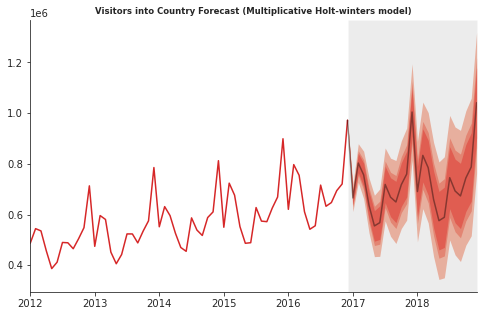

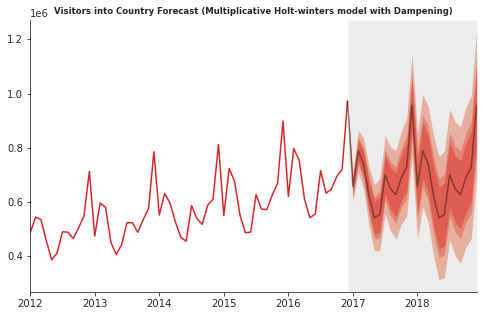

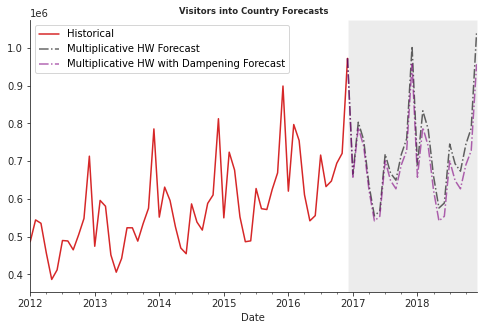

In [95]:
h=24

mhw1=forecast.holtwinters(y, additive=False, damped=False, m=12)
mhw1.fit()

mhw2=forecast.holtwinters(y, additive=False, damped=True, m=12)
mhw2.fit()

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='M')

pred1=pd.Series(mhw1.forecast(h), index=test)
# pred=np.exp(pred+var/2) # retransformation under the assumption of normality, for simplicity

intv1=pd.DataFrame(mhw1.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(mhw1.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(mhw1.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(y['01-2012':], pred1, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Visitors into Country Forecast (Multiplicative Holt-winters model)', fontsize=8.5, fontweight='bold')
sns.despine()
plt.show()

pred2=pd.Series(mhw.forecast(h), index=test)
# pred=np.exp(pred+var/2) # retransformation under the assumption of normality, for simplicity

intv1=pd.DataFrame(mhw2.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(mhw2.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(mhw2.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(y['01-2012':], pred2, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Visitors into Country Forecast (Multiplicative Holt-winters model with Dampening)', fontsize=8.5, fontweight='bold')
sns.despine()
plt.show()

last = y['01-2012':].iloc[-1:]

extended = last.append(pred1)
extended1 = last.append(pred2)

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8,5))
    y['01-2012':].plot(color='#D62728', label='Historical')
    extended.plot(color='black', linestyle='-.', alpha=0.6, label='Multiplicative HW Forecast')
    extended1.plot(color='purple', linestyle='-.', alpha=0.6, label='Multiplicative HW with Dampening Forecast')
    hold=ax.get_ylim()
    ax.fill_betweenx(ax.get_ylim(), extended.index[0], extended.index[-1], facecolor='grey', alpha=0.15)
    ax.set_ylim(hold)

plt.legend(loc='upper left')

plt.title('Visitors into Country Forecasts', fontsize=8.5, fontweight='bold')
sns.despine()
plt.show()

Given the results of the above models there was a slight difference in the RMSE and SE scores. The predictions were also slightly different, where the model with dampening had lower values compared to without dampening. While the differences in performance and forecassting were basically negligible the best model to consider would be the one with dampening. This was since the upward trend of the most recent observations shows the potential for continued increasing growth 

### Conclusion